<a href="https://colab.research.google.com/github/nalymugwe/The-MLC-Projects/blob/main/Android_Malware_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries 


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Import Data And Preprocessing

In [5]:
#check working directory
!pwd


/content


In [6]:
# Mount colab onto Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Import OS and see list of files
import os
os.chdir('/content/gdrive/MyDrive/Data Science/ML Company 30Day ML Aug Challenge/Android App Malware Detection Files')
!ls

Mounted at /content/gdrive
'Android Malware Detection.ipynb'
'Android Malware Detection using meta-information.pdf'
 Android_Permission.csv
'Dataset Details.pdf'
 logs.log
 n_estimators_vs_learning_rate.png


In [7]:
# Import the data
Data = pd.read_csv('/content/gdrive/MyDrive/Data Science/ML Company 30Day ML Aug Challenge/Android App Malware Detection Files/Android_Permission.csv')
Data.head()

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,Default : Access DRM content. (S),Default : Access Email provider data (S),Default : Access all system downloads (S),Default : Access download manager. (S),Default : Advanced download manager functions. (S),Default : Audio File Access (S),Default : Install DRM content. (S),Default : Modify Google service configuration (S),Default : Modify Google settings (S),Default : Move application resources (S),Default : Read Google settings (S),Default : Send download notifications. (S),Default : Voice Search Shortcuts (S),Default : access SurfaceFlinger (S),Default : access checkin properties (S),Default : access the cache filesystem (S),Default : access to passwords for Google accounts (S),Default : act as an account authenticator (S),Default : bind to a wallpaper (S),Default : bind to an input method (S),Default : change screen orientation (S),Default : coarse (network-based) location (S),Default : control location update notifications (S),Default : control system backup and restore (S),Default : delete applications (S),Default : delete other applications' caches (S),Default : delete other applications' data (S),Default : directly call any phone numbers (S),Default : directly install applications (S),Default : disable or modify status bar (S),...,Your accounts : access other Google services (D),Your accounts : act as an account authenticator (D),Your accounts : act as the AccountManagerService (S),Your accounts : contacts data in Google accounts (D),Your accounts : discover known accounts (S),Your accounts : manage the accounts list (D),Your accounts : read Google service configuration (S),Your accounts : use the authentication credentials of an account (D),Your accounts : view configured accounts (S),Your location : access extra location provider commands (S),Your location : coarse (network-based) location (D),Your location : fine (GPS) location (D),Your location : mock location sources for testing (D),Your messages : Read Email attachments (D),Your messages : Send Gmail (S),Your messages : edit SMS or MMS (D),Your messages : modify Gmail (D),Your messages : read Gmail (D),Your messages : read Gmail attachment previews (D),Your messages : read SMS or MMS (D),Your messages : read instant messages (D),Your messages : receive MMS (D),Your messages : receive SMS (D),Your messages : receive WAP (D),Your messages : send SMS-received broadcast (S),Your messages : send WAP-PUSH-received broadcast (S),Your messages : write instant messages (D),Your personal information : add or modify calendar events and send email to guests (D),Your personal information : choose widgets (S),Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S),Class
0,Canada Post Corporation,com.canadapost.android,Business,Canada Post Mobile App gives you access to som...,3.1,77,0.00,"{com.adaffix.pub.ca.android, com.kevinquan.gas...",7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,Word Farm,com.realcasualgames.words,Brain & Puzzle,Speed and strategy combine in this exciting wo...,4.3,199,0.00,"{air.com.zubawing.FastWordLite, com.joybits.do...",3.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fortunes of War FREE,fo

# Exploratory Data Analysis

In [8]:
Data.describe()

,Rating,Number of ratings,Price,Dangerous permissions count,Safe permissions count,Default : Access DRM content. (S),Default : Access Email provider data (S),Default : Access all system downloads (S),Default : Access download manager. (S),Default : Advanced download manager functions. (S),Default : Audio File Access (S),Default : Install DRM content. (S),Default : Modify Google service configuration (S),Default : Modify Google settings (S),Default : Move application resources (S),Default : Read Google settings (S),Default : Send download notifications. (S),Default : Voice Search Shortcuts (S),Default : access SurfaceFlinger (S),Default : access checkin properties (S),Default : access the cache filesystem (S),Default : access to passwords for Google accounts (S),Default : act as an account authenticator (S),Default : bind to a wallpaper (S),Default : bind to an input method (S),Default : change screen orientation (S),Default : coarse (network-based) location (S),Default : control location update notifications (S),Default : control system backup and restore (S),Default : delete applications (S),Default : delete other applications' caches (S),Default : delete other applications' data (S),Default : directly call any phone numbers (S),Default : directly install applications (S),Default : disable or modify status bar (S),Default : discover known accounts (S),Default : display unauthorized windows (S),Default : enable or disable application components (S),Default : force application to close (S),Default : force device reboot (S),...,Your accounts : access other Google services (D),Your accounts : act as an account authenticator (D),Your accounts : act as the AccountManagerService (S),Your accounts : contacts data in Google accounts (D),Your accounts : discover known accounts (S),Your accounts : manage the accounts list (D),Your accounts : read Google service configuration (S),Your accounts : use the authentication credentials of an account (D),Your accounts : view configured accounts (S),Your location : access extra location provider commands (S),Your location : coarse (network-based) location (D),Your location : fine (GPS) location (D),Your location : mock location sources for testing (D),Your messages : Read Email attachments (D),Your messages : Send Gmail (S),Your messages : edit SMS or MMS (D),Your messages : modify Gmail (D),Your messages : read Gmail (D),Your messages : read Gmail attachment previews (D),Your messages : read SMS or MMS (D),Your messages : read instant messages (D),Your messages : receive MMS (D),Your messages : receive SMS (D),Your messages : receive WAP (D),Your messages : send SMS-received broadcast (S),Your messages : send WAP-PUSH-received broadcast (S),Your messages : write instant messages (D),Your personal information : add or modify calendar events and send email to guests (D),Your personal information : choose widgets (S),Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S),Class
count,29999.000000,2.999900e+04,29999.000000,29795.000000,29999.000000,29999.000000,29999.000000,29999.0,29999.000000,29999.000000,29999.000000,29999.000000,29999.0,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.0,29999.0,29999.000000,29999.000000,29999.000000,29999.0,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.0,29999.000000,29999.000000,29999.000000,29999.000000,...,

In [9]:
# get info on the data
pd.set_option('display.max_info_columns', len(Data.columns)) #To get info an all the columns
Data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 184 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   App                                                                                     29998 non-null  object 
 1   Package                                                                                 29999 non-null  object 
 2   Category                                                                                29999 non-null  object 
 3   Description                                                                             29996 non-null  object 
 4   Rating                                                                                  29999 non-null  float64
 5   Number of ratings                                                 

In [10]:
# Drop all columns with null values
zero_cols = [ col for col, is_zero in ((Data == 0).sum() == Data.shape[0]).items() if is_zero ]
Data.drop(zero_cols, axis=1, inplace=True)
Data.shape


(29999, 162)

In [11]:
# Drop all columns with object type
object_columns = Data.select_dtypes(['object']).columns
Data.drop(object_columns, inplace=True, axis=1) 
Data.shape

(29999, 157)

In [12]:
#Drop all rows woth missing values
Refined_Data = Data.dropna()
Refined_Data.shape


(29795, 157)

In [25]:
# Find the correlation of the features agaianst the target feature.
pd.set_option("display.max_columns", None)
corr_matrix = Refined_Data.corr()
print(corr_matrix["Class"].sort_values(ascending=False))

Class                                                                    1.000000
Price                                                                    0.135841
Your location : fine (GPS) location (D)                                  0.074385
Your location : mock location sources for testing (D)                    0.066551
Services that cost you money : directly call phone numbers (D)           0.055862
                                                                           ...   
Safe permissions count                                                  -0.082620
Your personal information : write Browser's history and bookmarks (D)   -0.087283
Network communication : full Internet access (D)                        -0.087815
Network communication : view network state (S)                          -0.144167
Rating                                                                  -0.215665
Name: Class, Length: 157, dtype: float64


In [2]:
pip install sweetviz

     |████████████████████████████████| 15.1 MB 182 kB/s 


In [14]:
# Import library
import sweetviz

EDA_report = sweetviz.analyze(Refined_Data, target_feat='Class')

                                             |          | [  0%]   00:00 -> (? left)

In [16]:
# Create whole report in form of HTML file
EDA_report.show_html('Report.html')

Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Summary from initial EDA


*  From the sweetviz vizualtization, it's hard to tell the closely related features with the target features. It's best to use other methods to pick the most significant features.

*   5 columns with objects were removed from the data as it doesn't influence the outcome of the target column. These object columns were names of Apps, Related Apps, Description and Package.
*  22 columns with zero values in each row were dropped from the data.
*  204 rows were removed from the data.
*  There are 157 columns including the target column. We would need to perform a preprocessing step of feature selection to find the features that are correlated with the target feature.





### Feature Selection

In [10]:
# Split the target variable from the other variables
y = Refined_Data.Class
X = Refined_Data.drop(['Class'], axis=1)

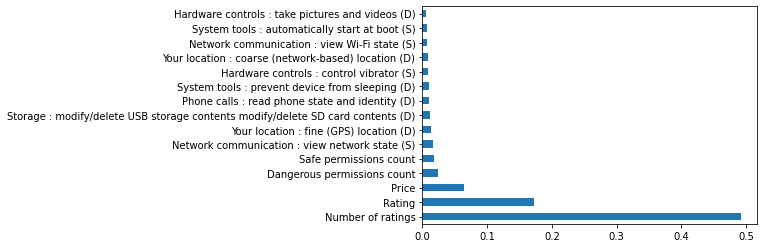

In [16]:
# Plot the important features

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X, y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [19]:
Selected_features = Refined_Data[["Number of ratings", "Rating", "Price", "Dangerous permissions count", "Safe permissions count", 
                          "Network communication : view network state (S)", "Your location : fine (GPS) location (D)", 
                          "Storage : modify/delete USB storage contents modify/delete SD card contents (D)", 
                          "Phone calls : read phone state and identity (D)", "System tools : prevent device from sleeping (D)", 
                          "Hardware controls : control vibrator (S)", "Your location : coarse (network-based) location (D)", 
                          "Network communication : view Wi-Fi state (S)", "System tools : automatically start at boot (S)", 
                          "Hardware controls : take pictures and videos (D)"]]                                       
X_Selected = Selected_features
X_Selected.shape                          

(29795, 15)

# Modelling 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [21]:
# Normalize the columns with continous feautures
scaler = MinMaxScaler() 
X_scaled = scaler.fit_transform(X_Selected)

# Split dataset into training set and test set, 70% training and 30% test
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3) 

# Fit model to training data
model = XGBClassifier()
model.fit(X_scaled_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Model Evaluation


In [22]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
y_pred=model.predict(X_scaled_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7244658239176641


# Hyperparameter Tuning

In [23]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

# grid Search CV
model = XGBClassifier()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_scaled, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.477979 using {'learning_rate': 0.1, 'n_estimators': 500}
-0.690190 (0.000058) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.687288 (0.000113) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.684440 (0.000167) with: {'learning_rate': 0.0001, 'n_estimators': 300}
-0.681647 (0.000219) with: {'learning_rate': 0.0001, 'n_estimators': 400}
-0.678908 (0.000271) with: {'learning_rate': 0.0001, 'n_estimators': 500}
-0.665951 (0.000524) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.643387 (0.000988) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.624438 (0.001383) with: {'learning_rate': 0.001, 'n_estimators': 300}
-0.608347 (0.001771) with: {'learning_rate': 0.001, 'n_estimators': 400}
-0.594588 (0.002115) with: {'learning_rate': 0.001, 'n_estimators': 500}
-0.548582 (0.003412) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.512032 (0.004629) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.499219 (0.005076) with: {'learning_rate': 0.01, 'n_e

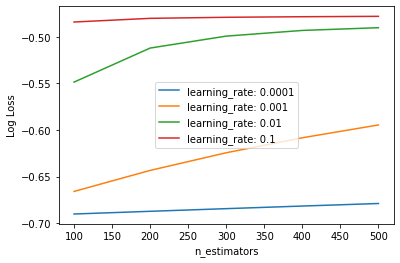

In [24]:
# plot results
import numpy as np
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')

In [25]:
#Incorporate the new paramater to a new model and check accuracy
tuned_model = XGBClassifier(learning_rate=0.1, n_estimators=500, random_state=42)
tuned_model.fit(X_scaled_train, y_train)

y_pred = tuned_model.predict(X_scaled_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7251370399373531


# Summary from Hyperparameter Tuning

The learning rate and number of boosting stages were changed to improve the accuracy of the model. The best predictor had a learning rate of 0.1 and 500 boosting stage that increased the accuracy by 1%. Let's test and see if the accuracy will improve if we add more boosting stages.

In [29]:
#Adding more boosting stages to check on the accuracy (n_estimators = 1000)
tuned_model2 = XGBClassifier(learning_rate=0.1, n_estimators=1000, random_state=42)
tuned_model2.fit(X_scaled_train, y_train)

y_pred2 = tuned_model2.predict(X_scaled_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy: 0.7249133012641235


In [30]:
#Adding more boosting stages to check on the accuracy (n_estimators = 2000)
tuned_model3 = XGBClassifier(learning_rate=0.1, n_estimators=2000, random_state=42)
tuned_model3.fit(X_scaled_train, y_train)

y_pred3 = tuned_model3.predict(X_scaled_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred3))

Accuracy: 0.7251370399373531


#Summary from increasing the number of boosting stages.

An increase in the number of boosting stages to 2000 slightly improved the accuracy of the model. 

# Prediction

In [31]:
y_pred3 = tuned_model3.predict(X_scaled_test)
print(y_pred3)

[0 0 1 ... 0 1 1]


In [43]:
#Print the first 5 transcations of the target test column
y_test.head()

17836    0
7027     1
21198    1
24991    0
21117    1
Name: Class, dtype: int64

# Model Explainability (Explainable AI)